Maintenant que l'on a notre meilleur modèle, on l'importe dans un nouveau notebook pour ne pas avoir à le faire tourner à chaque fois

# Import des librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn

# Import des données

In [2]:
df = pd.read_csv('donnée/data_rdy.csv')

In [3]:
train_df = df[df['TARGET'].notnull()]

# Destiné à Kaggle
test_df = df[df['TARGET'].isnull()]

# Import des pipeline

In [4]:
import joblib

In [5]:
pipe_fwto = joblib.load('Pipeline\search_logi_ftwo_1.joblib')
pipe_fwto_tuned = joblib.load('Pipeline\search_logi_ftwo_tuned.joblib')
pipe_roc_tuned = joblib.load('Pipeline\search_logi_roc_tuned.joblib')
pipe_roc = joblib.load('Pipeline\search_logi_roc_1.joblib')

In [6]:
pipe_fwto

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('sampling', SMOTE()),
                                             ('classification',
                                              LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'classification__C': array([1.00000000e-05, 1.02331658e-05, 1.04717682e-05, 1.07159340e-05,
       1.09657929e-05, 1.12214777e-05, 1.14831241e-05, 1.17508713e-05,
       1.20248614e-05, 1.23052400e-05, 1.25921561e-05, 1.2...
       0.00259502, 0.00271859, 0.00284804, 0.00298365, 0.00312572,
       0.00327455, 0.00343047, 0.00359381, 0.00376494, 0.00394421,
       0.00413201, 0.00432876, 0.00453488, 0.00475081, 0.00497702,
       0.00521401, 0.00546228, 0.00572237, 0.00599484, 0.00628029,
       0.00657933, 0.00689261, 0.00722081, 0.00756463, 0.00792483,
       0.00830218, 0.00869749, 0.00911163, 0.00954548, 0.01      ])},
                   random_state=0, scoring=make_scorer(fbeta_score, beta=10),
                   verbose=2)

# Préparation des données

In [7]:
# On retire les informations qui ne sont pas des features

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

# On fait une liste des feature corrélés avec la TARGET
correlation = train_df[feats].corrwith(train_df['TARGET'])

# On prend les 20 features qui sont le plus corrélés avec la Target

feature = list(correlation.abs().sort_values(ascending=False)[:20].index)

# On fait un dropna
train_rdy = train_df.dropna(subset = feature)
train_rdy

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
36,36,100043,0.0,1,0,0,2,198000.0,641173.5,23157.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,33.0
85,85,100100,0.0,0,1,0,2,202500.0,796396.5,38443.5,...,1.0,0.031915,3.0,0.031229,0.0,0.0,0.0,0.0,0.0,94.0
111,111,100131,0.0,1,0,0,0,270000.0,891072.0,45625.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,24.0
119,119,100139,0.0,1,0,1,1,157500.0,302341.5,24016.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,75.0
124,124,100145,0.0,1,1,0,1,202500.0,260725.5,16789.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307469,307473,456213,0.0,1,1,0,1,90000.0,258709.5,20439.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,34.0
307471,307475,456215,1.0,1,0,1,1,144000.0,1303200.0,46809.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,94.0
307475,307479,456219,0.0,1,0,0,1,112500.0,521280.0,31630.5,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,10.0
307496,307500,456244,0.0,1,0,0,0,261000.0,1303812.0,35982.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,41.0


In [8]:
# On récupère notre X et notre y

X = train_rdy[feature]
y = train_rdy['TARGET']

In [9]:
from sklearn.model_selection import train_test_split

# On prend un X_train et y_train

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)

# Test du Pipeline

In [10]:
# On va avoir besoin du fbeta score
from sklearn.metrics import fbeta_score

In [11]:
current_model = pipe_roc_tuned

y_predict = current_model.predict(X_test)

report_new = pd.DataFrame({'model':'search_gradiant','score':['ftwo'],'best_params':[current_model.best_params_],\
          'best_score':[current_model.best_score_],'train':[current_model.score(X_train, y_train)],\
          'test':[current_model.score(X_test, y_test)],'fbeta_score_test':[fbeta_score(y_test,y_predict,beta=10)]})

#report_final = pd.concat([report_final,report_new])
#report_final

report_new

,model,score,best_params,best_score,train,test,fbeta_score_test
0,search_gradiant,ftwo,"{'classification__tol': 0.0016297508346206436,...",0.669061,0.670158,0.672751,0.637546


In [12]:
# On a bien les même paramètre que dans le DataFrame précédent. L'import s'est fait sans problème.

# Feature importance

## Feature importance global

In [13]:
coefficient_fwto = pipe_fwto.best_estimator_.named_steps['classification'].coef_
coefficient_roc = pipe_roc.best_estimator_.named_steps['classification'].coef_

feature_importance_global = pd.DataFrame({'feature':X_train.columns,'coef_fwto':coefficient_fwto[0],\
                                          'coef_roc':coefficient_roc[0]})
feature_importance_global

,feature,coef_fwto,coef_roc
0,EXT_SOURCE_3,-2.282215e+00,-2.215059e+00
1,EXT_SOURCE_2,-1.749719e+00,-1.855932e+00
2,EXT_SOURCE_1,-2.702462e+00,-2.561053e+00
3,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,3.450782e-01,3.645673e-01
4,CC_CNT_DRAWINGS_CURRENT_MAX,2.806884e-02,2.606350e-02
5,BURO_DAYS_CREDIT_MEAN,2.363087e-04,1.449492e-04
6,CC_AMT_BALANCE_MEAN,2.727933e-06,7.862295e-07
7,CC_AMT_TOTAL_RECEIVABLE_MEAN,1.782588e-06,1.623836e-06
8,CC_AMT_RECIVABLE_MEAN,1.475536e-06,8.791345e-07
9,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,2.316498e-07,1.447324e-06


# Matrice de confusion + Rapport

On va faire la matrice de confusion et faire un rapport de la classification

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [15]:
# On teste avec un modèle baseline

baseline = np.full(len(y_test),0)
print("\n\nClassification Report\n\n")
print(classification_report(y_test, baseline))



Classification Report


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      1735
         1.0       0.00      0.00      0.00       152

    accuracy                           0.92      1887
   macro avg       0.46      0.50      0.48      1887
weighted avg       0.85      0.92      0.88      1887



C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
np.unique(y_test,return_counts=True)

(array([0., 1.]), array([1735,  152], dtype=int64))

In [16]:
y_pred = pipe_roc_tuned.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print('Matrice de confusion\n\n', cm)
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
print("\n\nClassification Report\n\n")
print(classification_report(y_test, y_pred))

Matrice de confusion

 [[1193  542]
 [  52  100]]

True Negatives(TN) =  1193

True Positives(TP) =  100

False Positives(FP) =  542

False Negatives(FN) =  52


Classification Report


              precision    recall  f1-score   support

         0.0       0.96      0.69      0.80      1735
         1.0       0.16      0.66      0.25       152

    accuracy                           0.69      1887
   macro avg       0.56      0.67      0.53      1887
weighted avg       0.89      0.69      0.76      1887



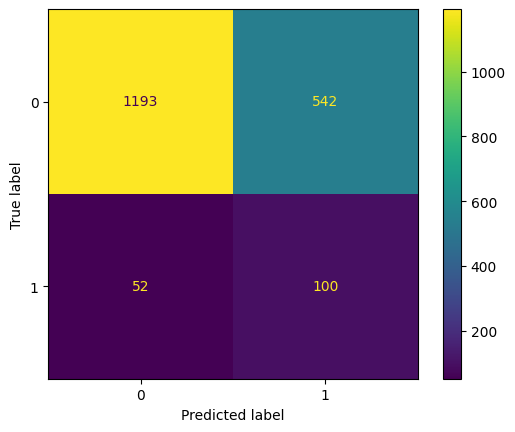

In [17]:
# On fait un graphique de la matrice de confusion

y_pred = pipe_roc_tuned.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot();

In [18]:
y_pred = pipe_roc_tuned.predict(X_test)

# On affiche les pourcentages

cm_no_perc = confusion_matrix(y_test, y_pred,normalize='all')
cm = np.array([[f"{i:.2%}" for i in val] for val in cm_no_perc])
print('Matrice de confusion\n\n', cm)
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
#print("\n\nClassification Report\n\n")
#print(classification_report(y_test, y_pred))

Matrice de confusion

 [['63.22%' '28.72%']
 ['2.76%' '5.30%']]

True Negatives(TN) =  63.22%

True Positives(TP) =  5.30%

False Positives(FP) =  28.72%

False Negatives(FN) =  2.76%


In [19]:
# On test la version fine_tune avec le threshold séléctionné
# On affiche les pourcentages
def threshold_test(threshold):
    return  np.array(pd.DataFrame(pipe_roc_tuned.predict_proba(X_test))[1].apply(lambda x : 1 if (x >= threshold)else 0))

y_pred = threshold_test(0.4)

cm_no_perc = confusion_matrix(y_test, y_pred,normalize='all')
cm = np.array([[f"{i:.2%}" for i in val] for val in cm_no_perc])
print('Matrice de confusion\n\n', cm)
print('\nTrue Negatives(TN) = ', cm[0,0])
print('\nTrue Positives(TP) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
print("\n\nClassification Report\n\n")
print(classification_report(y_test, y_pred))

Matrice de confusion

 [['50.50%' '41.44%']
 ['1.80%' '6.25%']]

True Negatives(TN) =  50.50%

True Positives(TP) =  6.25%

False Positives(FP) =  41.44%

False Negatives(FN) =  1.80%


Classification Report


              precision    recall  f1-score   support

         0.0       0.97      0.55      0.70      1735
         1.0       0.13      0.78      0.22       152

    accuracy                           0.57      1887
   macro avg       0.55      0.66      0.46      1887
weighted avg       0.90      0.57      0.66      1887



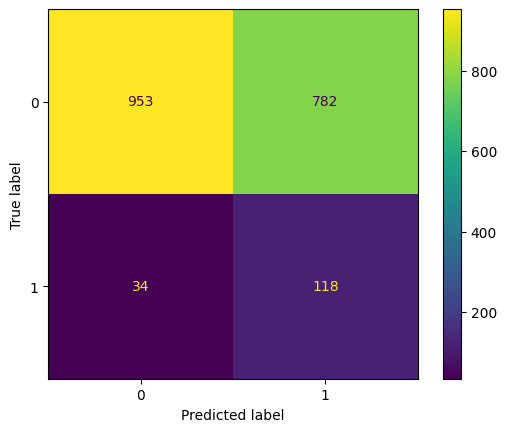

In [20]:
# On fait un graphique de la matrice de confusion avec un seuil de 0.4

y_pred = threshold_test(0.4)

cm= confusion_matrix(y_test, y_pred)

cmd = ConfusionMatrixDisplay(cm, display_labels=[0,1])
cmd.plot();

# Feature importance local

## Lime

Liens vers la documentation utilisé :

https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

In [21]:
from lime import lime_tabular

In [22]:
classe = ['Crédit accordé','Crédit refusé']

explainer = lime_tabular.LimeTabularExplainer(np.array(X_train), mode="classification",
                                              class_names=classe,
                                              feature_names=feature,
                                             )

explainer

In [23]:
import random

In [24]:
idx = random.randint(1, len(X_test))

print("Prediction : ", classe[int(pipe_fwto.predict(np.array(X_test)[idx].reshape(1,-1))[0])])
print("Actual :     ", classe[int(np.array(y_test)[idx])])

explanation = explainer.explain_instance(np.array(X_test)[idx], pipe_fwto.predict_proba,
                                         num_features=len(feature))

explanation.show_in_notebook()

Prediction :  Crédit refusé
Actual :      Crédit accordé


C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Feature importance for wrong prediction

In [25]:
preds = pipe_fwto.predict(X_test)

false_preds = np.argwhere((preds != np.array(y_test))).flatten()

idx  = random.choice(false_preds)

print("Prediction : ", classe[int(pipe_fwto.predict(np.array(X_test)[idx].reshape(1,-1))[0])])
print("Actual :     ", classe[int(np.array(y_test)[idx])])

explanation = explainer.explain_instance(np.array(X_test)[idx], pipe_fwto.predict_proba,num_features=len(feature))

explanation.show_in_notebook()

Prediction :  Crédit refusé
Actual :      Crédit accordé


C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\Louis\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


# Test de divers fonctions pour le streamlit

In [26]:
explanation.as_list()

[('EXT_SOURCE_1 <= 0.33', 0.1807648418067625),
 ('EXT_SOURCE_3 <= 0.31', 0.14285298398305638),
 ('DAYS_BIRTH > -11966.25', -0.11271391855041683),
 ('1527.99 < CC_AMT_INST_MIN_REGULARITY_MEAN <= 3657.84', 0.10854874656000413),
 ('22278.80 < CC_AMT_BALANCE_MEAN <= 68218.27', -0.051171791774022694),
 ('0.06 < CC_CNT_DRAWINGS_ATM_CURRENT_MEAN <= 0.27', -0.046643394967293285),
 ('22079.22 < CC_AMT_RECIVABLE_MEAN <= 67828.64', -0.039259531312084935),
 ('BURO_MONTHS_BALANCE_SIZE_MEAN > 36.50', -0.03569885402194067),
 ('22079.22 < CC_AMT_TOTAL_RECEIVABLE_MEAN <= 67828.64',
  -0.026678617051121283),
 ('0.78 < CC_CNT_DRAWINGS_CURRENT_MEAN <= 2.58', 0.022546854430079182),
 ('65509.81 < CC_AMT_RECEIVABLE_PRINCIPAL_MEAN <= 145798.86',
  -0.020643474658856898),
 ('BURO_DAYS_CREDIT_MIN <= -2606.00', 0.01988354796371172),
 ('0.40 < BURO_CREDIT_ACTIVE_Active_MEAN <= 0.60', 0.012929213925093502),
 ('-3249.00 < DAYS_EMPLOYED <= -1783.00', 0.011874357476155888),
 ('0.00 < PREV_NAME_CONTRACT_STATUS_Refused

In [27]:
import re

liste = []
for i in explanation.as_list():
    if len(re.split('>|<',i[0]))==2:
        liste.append(re.split('>|<',i[0])[0].strip())
    else :
        liste.append(re.split('>|<',i[0])[1].strip())
liste

['EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'CC_AMT_INST_MIN_REGULARITY_MEAN',
 'CC_AMT_BALANCE_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'CC_AMT_RECIVABLE_MEAN',
 'BURO_MONTHS_BALANCE_SIZE_MEAN',
 'CC_AMT_TOTAL_RECEIVABLE_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_MEAN',
 'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'DAYS_EMPLOYED',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'EXT_SOURCE_2',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'BURO_DAYS_CREDIT_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_MAX',
 'PREV_CODE_REJECT_REASON_XAP_MEAN']

In [28]:
liste = []
liste

[]

In [29]:
explanation.predict_proba

array([0.35407125, 0.64592875])

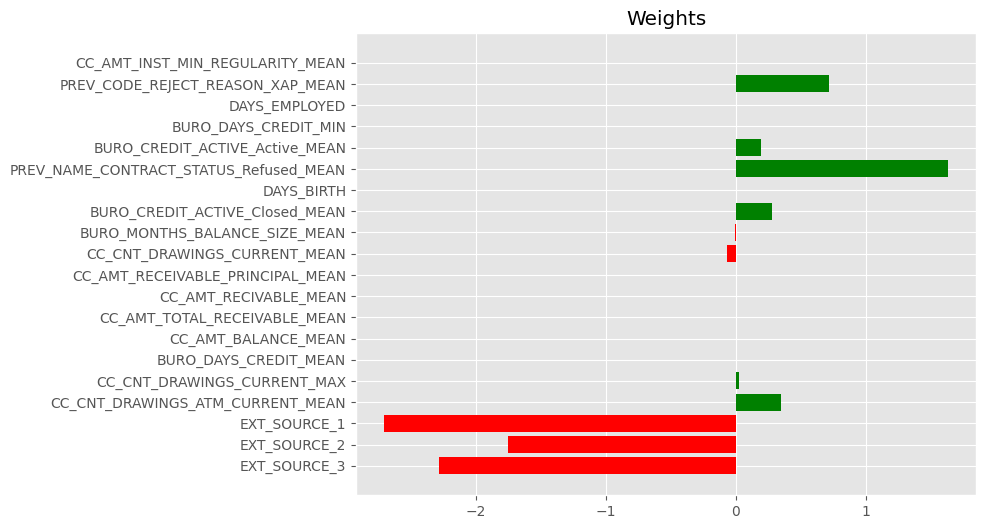

In [30]:
lr = pipe_fwto.best_estimator_.named_steps['classification']

with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(8,6))
    plt.barh(range(len(lr.coef_[0])), lr.coef_[0], color=["red" if coef<0 else "green" for coef in lr.coef_[0]])
    plt.yticks(range(len(lr.coef_[0])), feature);
    plt.title("Weights")
plt.show()

In [31]:
lr.coef_[0]

array([-2.28221515e+00, -1.74971872e+00, -2.70246189e+00,  3.45078217e-01,
        2.80688419e-02,  2.36308697e-04,  2.72793305e-06,  1.78258816e-06,
        1.47553627e-06,  2.31649789e-07, -6.99944269e-02, -6.92668784e-03,
        2.81919142e-01, -1.09922389e-04,  1.63096681e+00,  1.95855826e-01,
       -9.33215070e-05,  8.98807089e-05,  7.21240969e-01, -1.34796483e-04])

In [32]:
X.columns.values

array(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1',
       'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MAX',
       'BURO_DAYS_CREDIT_MEAN', 'CC_AMT_BALANCE_MEAN',
       'CC_AMT_TOTAL_RECEIVABLE_MEAN', 'CC_AMT_RECIVABLE_MEAN',
       'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN', 'CC_CNT_DRAWINGS_CURRENT_MEAN',
       'BURO_MONTHS_BALANCE_SIZE_MEAN', 'BURO_CREDIT_ACTIVE_Closed_MEAN',
       'DAYS_BIRTH', 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
       'BURO_CREDIT_ACTIVE_Active_MEAN', 'BURO_DAYS_CREDIT_MIN',
       'DAYS_EMPLOYED', 'PREV_CODE_REJECT_REASON_XAP_MEAN',
       'CC_AMT_INST_MIN_REGULARITY_MEAN'], dtype=object)

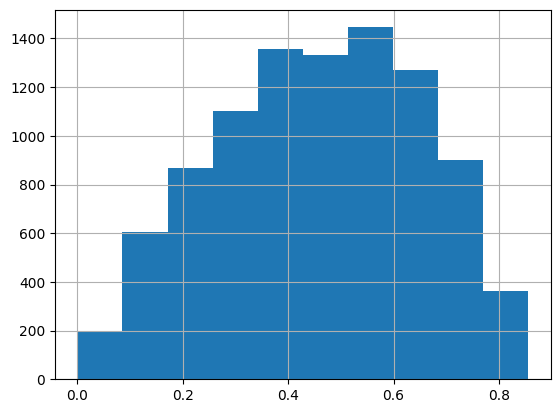

In [33]:
X['EXT_SOURCE_3'].hist()

plt.show()

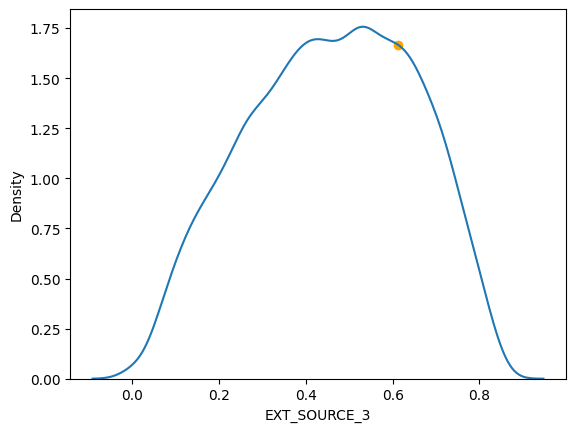

In [34]:
idx = random.randint(1, len(X))

#sns.histplot(np.array(X['EXT_SOURCE_3'])[idx])
ax = sns.kdeplot(X['EXT_SOURCE_3'])
x = ax.lines[0].get_xdata()
y = ax.lines[0].get_ydata()
ax.scatter(np.array(X['EXT_SOURCE_3'])[idx],y[np.argmin(abs(list(x) - np.array(X['EXT_SOURCE_3'])[idx]))],color='orange')
#plt.scatter(np.array(X['EXT_SOURCE_3'])[idx],0)
plt.show()

In [35]:
np.argmin(abs(list(x) - np.array(X['EXT_SOURCE_3'])[idx]))

135

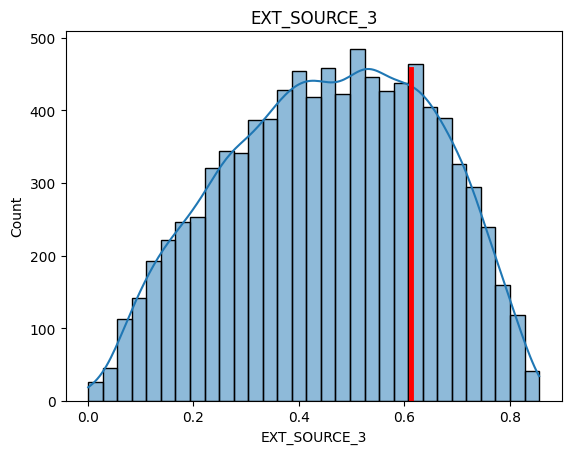

In [36]:
ax = sns.histplot(X['EXT_SOURCE_3'], kde=True)
#plt.scatter(np.array(X['EXT_SOURCE_3'])[idx],np.argmin(abs(list(x) - np.array(X['EXT_SOURCE_3'])[idx])))
y = ax.lines[0].get_ydata()
max_height = max(y)
plt.title('EXT_SOURCE_3')
ax.plot([np.array(X['EXT_SOURCE_3'])[idx],np.array(X['EXT_SOURCE_3'])[idx]],[0,max_height],color = 'red',linewidth=3.5)
plt.show()

In [37]:
liste = []
for i in explanation.as_list():
    if len(re.split('>|<',i[0]))==2:
        liste.append(re.split('>|<',i[0])[0].strip())
    else :
        liste.append(re.split('>|<',i[0])[1].strip())
liste

['EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'CC_AMT_INST_MIN_REGULARITY_MEAN',
 'CC_AMT_BALANCE_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'CC_AMT_RECIVABLE_MEAN',
 'BURO_MONTHS_BALANCE_SIZE_MEAN',
 'CC_AMT_TOTAL_RECEIVABLE_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_MEAN',
 'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'DAYS_EMPLOYED',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'EXT_SOURCE_2',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'BURO_DAYS_CREDIT_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_MAX',
 'PREV_CODE_REJECT_REASON_XAP_MEAN']

In [38]:
liste = liste[:2]
liste

['EXT_SOURCE_1', 'EXT_SOURCE_3']

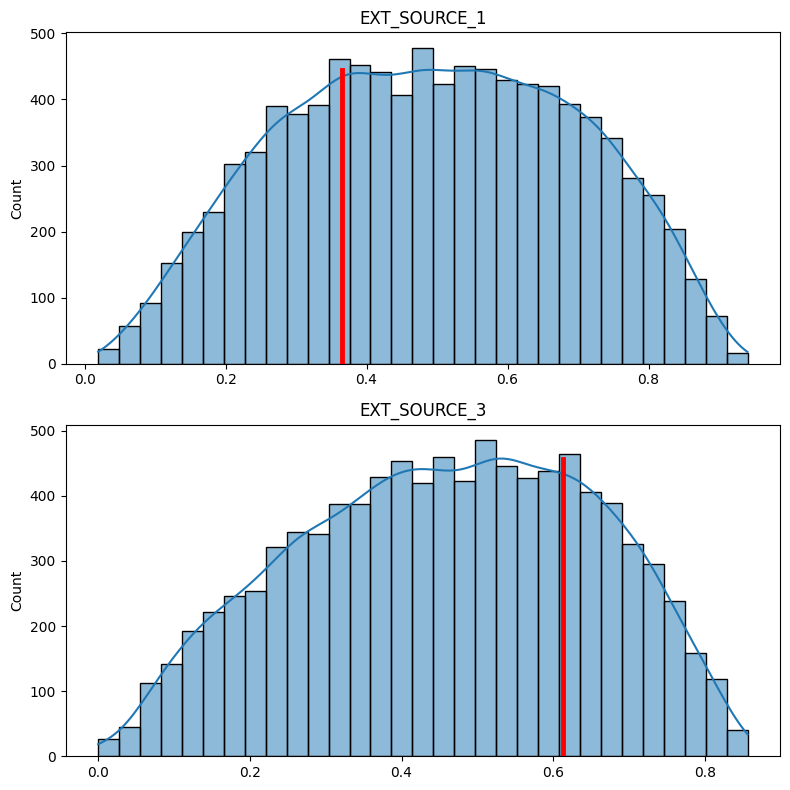

In [39]:
l = len(liste)

fig,axes = plt.subplots(l,1,figsize=(8,4*l),tight_layout=True)
j=0
for f in liste :
    ax = axes[j]
    sns.histplot(X[f], kde=True,ax=ax)
    #plt.scatter(np.array(X['EXT_SOURCE_3'])[idx],np.argmin(abs(list(x) - np.array(X['EXT_SOURCE_3'])[idx])))
    y = ax.lines[0].get_ydata()
    max_height = max(y)
    ax.set_title(f)
    ax.set_xlabel('')
    ax.plot([np.array(X[f])[idx],np.array(X[f])[idx]],[0,max_height],color = 'red',linewidth=3.5)
    j+=1
plt.show()

In [40]:
len(liste)

2

In [41]:
liste

['EXT_SOURCE_1', 'EXT_SOURCE_3']